In [37]:
import numpy as np
import sklearn as sk
import sklearn.datasets as sk_ds
import sklearn.svm as sk_svm
import matplotlib.pyplot as plt

In [38]:
wbc_features, wbc_targets = sk_ds.load_breast_cancer(True)
print('WBC: Zbiór {} danych z {} cechami'.format(len(wbc_targets),
                                                 wbc_features.shape[1]))

WBC: Zbiór 569 danych z 30 cechami


## SVM

### Klasyfikator liniowy

$$ y = f(\vec{w} \cdot \vec{x}) = f(\sum_i w_i x_i)  $$

$\vec{w}$ - wektor wag klasyfikatora

$\vec{x}$ - wektor wejściowy cech

$f$ - funkcja decyzyjna $\Re \to N $ odwzorowuje zbiór liczb rzeczywistych na klasę 

Dla dwóch klas funkcja $f$ zazwyczaj przypisuje iloczyn skalarny do jednej klasy jeśli jest on większy od pewnej wartości i do drugiej klasy jeśli nie jest. W takim przypadku klasyfikator liniowy dzieli przestrzeń wejściową za pomocą hiperpłaszczyzny, czyli uogólnienia płaszczyzny do n-wymiarów.

Dla takiego przypadku hiperpłaszczyzna w klasyfikatorze liniowym może być opisana jako zbiór puntów $\vec x$ dla których zachodzi $ \vec w \cdot \vec x - b = 0 $.

0.875


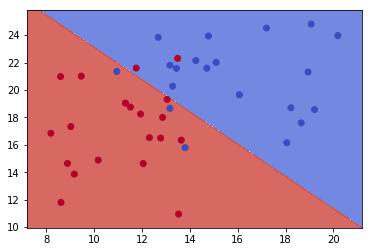

In [50]:
def plot_svm_2d(ax, data, labels, classifier, plot_hyperplanes=False):
  min_x = data[:,0].min() - 1
  max_x = data[:,0].max() + 1
  min_y = data[:,1].min() - 1
  max_y = data[:,1].max() + 1
  
  xx, yy = np.meshgrid(np.arange(min_x, max_x, 0.01),
                       np.arange(min_y, max_y, 0.01))
  Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
  ax.scatter(data[:,0], data[:,1], c=labels, cmap=plt.cm.coolwarm)
  
  # Hyperplane
  if plot_hyperplanes:
    w = classifier.coef_[0]
    a = -w[0] / w[1]
    xx2 = np.linspace(min_x, max_x)
    yy2 = a * xx2 - (classifier.intercept_[0]) / w[1]
  
    margin = 1 / np.sqrt(np.sum(classifier.coef_ ** 2))
    yy_down = yy2 - np.sqrt(1 + a ** 2) * margin
    yy_up = yy2 + np.sqrt(1 + a ** 2) * margin


    ax.plot(xx2, yy2, 'k-')
    ax.plot(xx2, yy_down, 'k--')
    ax.plot(xx2, yy_up, 'k--')
  
  ax.set_xlim(min_x, max_x)
  ax.set_ylim(min_y, max_y)

def make_linear(fig, plot_hyperplanes=False,
                C=1.0, kernel='linear', **kwargs):
  in_features = wbc_features[40:80,:2]
  out_targets = wbc_targets[40:80]
  
  classifier = sk_svm.SVC(kernel=kernel, C=C, **kwargs)
  classifier.fit(in_features, out_targets)
  plot_svm_2d(fig, in_features, out_targets, classifier, plot_hyperplanes)
  return classifier.score(in_features, out_targets)

  


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
score = make_linear(ax)
print(score)
plt.show()

### Klasyfikator SVM

SVM (ang. Support Vector Machine) jest to rodzaj klasyfikatora liniowego. Polega on na wyznaczeniu hiperpłaszczyzny tak, aby margines pomiędzy hiperpłaszczyzną i najbliższymi punktami (wektorami nośnymi - support vectors) był jak największy.

W tym celu definiujemy dwie dodatkowe hiperpłaszczyzny, równoległe do wspomnianej poprzednio, o równaniach:

$$
\vec w \cdot \vec x - b = 1
$$
$$
\vec w \cdot \vec x - b = -1
$$

Odpowiadają one hiperpłaszczyznom granicznym, opartym na wektorach nośnych.

Odległość między tym płaszczyznami to $\frac{2}{\|\vec w \|}$, naszym zadaniem jest więc minimaliacja

Minimalizuje $\|\vec{w}\|$ tak aby zachodziło równanie:

$$y_i (\vec{w} \cdot \vec{x}_i - b) \ge 1$$

, gdzie 

$\vec{w}$ - wektor wag klasyfikatora, 

$b$ - hiperpłaszczyzna, 

$\vec{x}_i$ - punkty zbioru treningowego, 

$y_i$ - klasa $\{-1, 1\}$ do której należy punkt $x_i$

Równanie to działa tylko dla danych liniowo separowalnych, dla zbioru nieseparowalnego konieczne jest uogólnienie sformułowania:

Zminimalizuj 
$$\| w \|^2 + C \sum_i \xi_i $$
tak aby zachodziło 
$$y_i(\vec w \cdot \vec x_i - b) \ge 1 - \xi_i,\ \xi_i \ge 0,\ i=1,...,n$$

, gdzie

$\xi_i$ - współczynnik błędu dla danego punktu (*"jak daleko wchodzi do złej klasy"*)

$C$ - współczynnik określający stosunek między zwiększeniem marginesu, a minimalizacją błędów

### Postać dualna


Takie sformułowanie oznacza problem znalezienia ekstremum warunkowego. W celu efektywnego rozwiązania tego problemu przy pomocy metod numerycznych stosuje się metodę mnożników Lagrange'a.
W tym celu problem przekształcony jest do postaci dualnej:

Zakładając, że 
$$\vec w = \sum_i \alpha_i y_i \vec x_i$$
zmaksymalizuj 
$$
W(\vec \alpha)=\sum_i \alpha_i - \frac 1 2 \sum_i \sum_j \alpha_i \alpha_j y_i y_j (\vec x_i \cdot \vec x_j)
$$
, tak aby zachodziło $\sum_i \alpha_i y_i = 0$ oraz $0\le \alpha_i \le C $ dla $i = 1,..,n$.

Jedynymi wektorami dla których $\alpha_i \ne 0$ są wektory nośne.

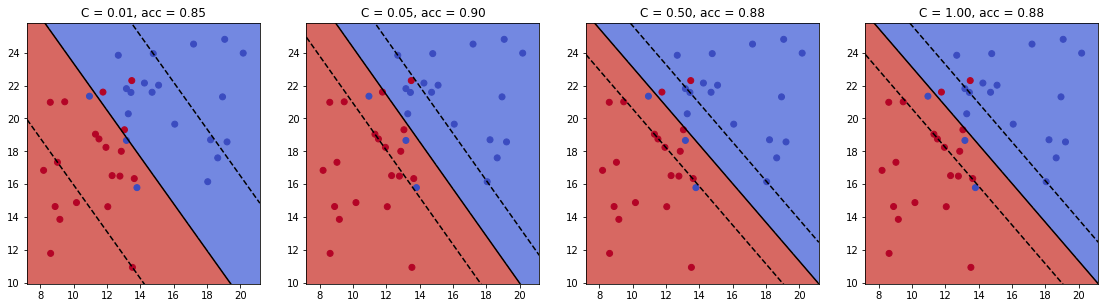

In [40]:
plt.clf()
fig = plt.figure(figsize=(6.4*3, 4.8))
Cs = [0.005, 0.05, 0.5, 1.0]
for i, c in enumerate(Cs):
  ax = fig.add_subplot(1, len(Cs), i + 1)
  accuracy = make_linear(ax, True, C=c)
  ax.set_title("C = {:2.2f}, acc = {:2.2f}".format(c, accuracy))
plt.show()

### Trik kernelowy

Klasyfkator liniowy, a więc i SVM może poprawnie klasyfikować tylko dane liniowo separowalne, co stanowi bardzo wąską klasę problemów. W tym celu stosuje się **trik kernelowy** oparty na idei, że dane nieseparowalne w *n*-wymiarach mogą być liniowo separowalne w wyższych wymiarach, *n*+1, *n*+2, itd.

W tym celu definiujemy nieliniowe przekształcenie punktów wejściowych $\phi(\vec x_i)$ oraz funkcję kernela $k(\vec x_i, \vec x_j)$ spełniającą zależność $k(\vec x_i,\vec x_j ) = \phi(\vec x_i) \cdot \phi(\vec x_j)$.

Na przykład transformacja dodająca dodatkową współrzędną zawierającą odległość od środka układu współrzędnych:
$$
\phi(x): \Re_2 \to \Re_3 
$$
$$
\phi((x_1, x_2)) = (x_1, x_2, \sqrt {x_1^2 + x_2^2})
$$

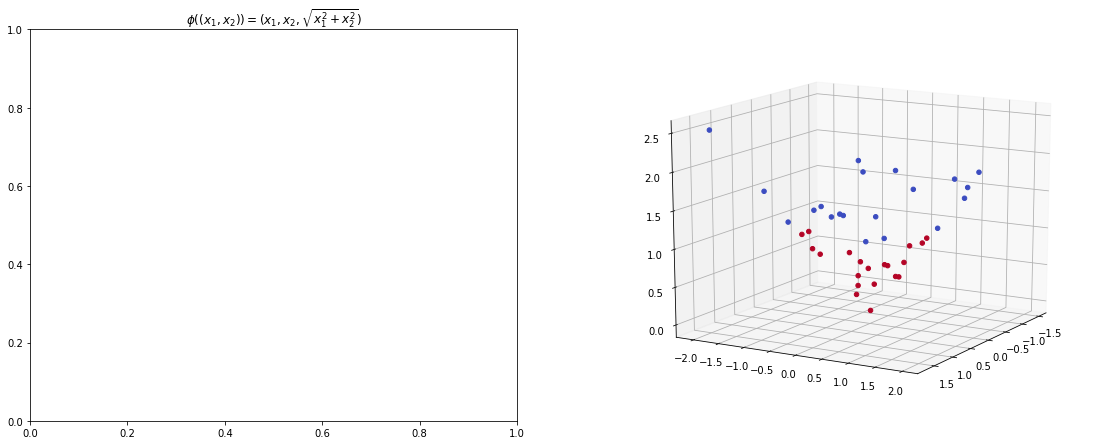

In [41]:
def phi(X):
  result = np.zeros((X.shape[0], X.shape[1] + 1))
  result[:, :2] = X
  result[:, 2] = np.sqrt(X[:, 0]**2 + X[:, 1]**2)
  return result

def circle_kernel(X, X_fit):
  return np.dot(phi(X), phi(X_fit).T)
  

def circle():
  from mpl_toolkits.mplot3d import Axes3D
  
  coordinates = np.random.randn(40, 2)
  labels = np.zeros((40,))
  labels[coordinates[:,0]**2 + coordinates[:,1]**2 <= 1.2] = 1
  
  classifier = classifier = sk_svm.SVC(kernel=circle_kernel)
  classifier.fit(coordinates, labels)
  
  figure = plt.figure(figsize=(6.4*2*1.5, 4.8*1.5))
  ax = figure.add_subplot(1, 2, 1)
  
  plot_svm_2d(figure, coordinates, labels, classifier)
  ax.set_title('$\phi((x_1, x_2)) = (x_1, x_2, \sqrt{x_1^2 + x_2^2})$')
  ax = figure.add_subplot(1, 2, 2, projection='3d')
  projected = phi(coordinates)
  ax.scatter(projected[:, 0], projected[:,1], projected[:,2], c=labels,
             cmap=plt.cm.coolwarm, depthshade=False)
  ax.view_init(15, 30)
  
plt.clf()
circle()
plt.show()
  

Podstawiając przekształcenie danych wejściowych do równań dla postaci dualnej, otrzymujemy:

Zakładając, że 
$$\vec w = \sum_i \alpha_i y_i \phi(\vec x_i)$$
zmaksymalizuj 
$$
W(\vec \alpha)=\sum_i \alpha_i - \frac 1 2 \sum_i \sum_j \alpha_i \alpha_j y_i y_j k(\vec x_i, \vec x_j)
$$
, tak aby zachodziło $\sum_i \alpha_i y_i = 0$ oraz $0\le \alpha_i \le C $ dla $i = 1,..,n$.

Najczęściej stosowanymi kernelami są:
- wielomianowy $k(\vec x_i, \vec x_j) = (\vec x_i \cdot \vec x_j + c)^d$
- Gaussowski $k(\vec x_i, \vec x_j) = \exp(-\frac{\|\vec x_i - \vec x_j \|^2}{2 \sigma^2})$
- sigmoidalny $k(\vec x_i, \vec x_j) = \tanh(\kappa(\vec x_i \cdot \vec x_j) + \Theta)$

c:\program files\python36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\program files\python36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


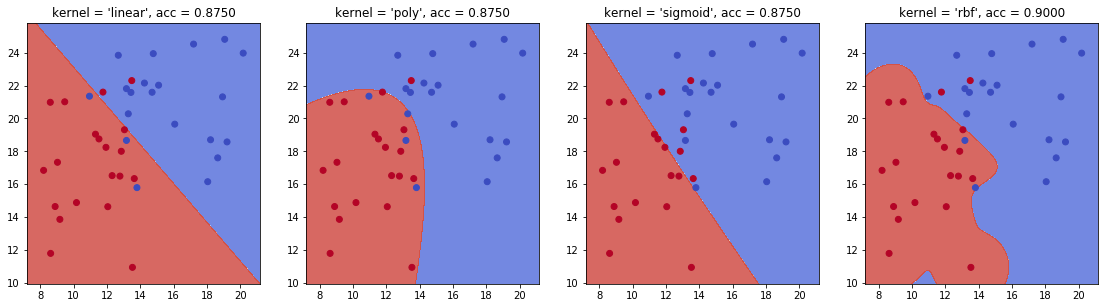

In [42]:
fig = plt.figure(figsize=(6.4*3, 4.8))
kernels = ['linear', 'poly', 'sigmoid', 'rbf']
kwargs = [dict(), dict(), dict(), dict()]
kwargs[2]['gamma'] = 0.0008
for i, kernel in enumerate(kernels):
  ax = fig.add_subplot(1, len(Cs), i + 1)
  accuracy = make_linear(ax, kernel=kernel, **kwargs[i])
  ax.set_title("kernel = '{}', acc = {:2.4f}".format(kernel, accuracy))
plt.show()

### Jakość klasyfikacji

## Działanie SVM

## Zadanie



In [43]:
import pandas

def get_values(final_type=np.int):
  """
  Get arrhythmia database.
  """
  
  # 13th column contains too much missing data to be usefull
  columns = list(range(13))+list(range(14, 280))

  arrhythmia = pandas.read_csv(
      'http://archive.ics.uci.edu/ml/machine-learning-databases/' \
      'arrhythmia/arrhythmia.data', header=None, usecols=columns)
  arrhythmia = arrhythmia.values

  # For other missing values we generate values with Gaussian distribution 
  # with mean and standard deviation of existing values
  def calculate_mean(column):
    return column[column != '?'].astype(np.float32).mean()

  def calculate_std(column):
    return column[column != '?'].astype(np.float32).std()

  missing_columns = set()
  for i, row in enumerate(arrhythmia):
    for j, value in enumerate(row):
      if value == '?':
        missing_columns.add(j)

  for col in missing_columns:
    mean = calculate_mean(arrhythmia[:, col])
    std = calculate_std(arrhythmia[:, col])
    for j in range(arrhythmia.shape[0]):
      if arrhythmia[j, col] == '?':
        arrhythmia[j, col] = np.random.normal(mean, std)

  features = arrhythmia[:,:278].astype(final_type)
  # We substitute one to get nicer {0,1} classes for binary classification
  targets = arrhythmia[:,278].astype(np.int) - 1
  
  # Remove classes with too few data
  for i in range(15):
    if np.sum(targets == i) < 5:
      features = features[targets != i,:]
      targets = targets[targets != i]
  return features, targets

features, targets = get_values()
binary_targets = np.copy(targets)
binary_targets[binary_targets > 0] = 1

print('Arrhythmia: Zbiór {} danych z {} cechami'.format(*features.shape))

# Number of cross-validation splits
splits = 5

# Metrics to report
# ==============================================================================
# TODO Add aditional metrics

def accuracy(result, target):
  return np.sum(result == target) / len(target) * 100

metrics = [accuracy]

# ==============================================================================


def test_classifier(builder, features, labels, metrics=metrics, *args, **kwargs):
  """
  builder - function producing the classifier to test
  args and kwargs will be passed to the builder
  
  Returns mean tuple (mean_accuracy, accuracy_deviation)
  """
  
  # Stratified KFold mainains class distribution in iterations
  fold = sk.model_selection.StratifiedKFold(splits)
  
  scores = []
  for train, test in fold.split(features, labels):
    # Build the model
    classifier = builder(*args, **kwargs)
    # Train it
    classifier.fit(features[train], labels[train])
    # Use it to predict test lables
    predicted = classifier.predict(features[test])
    score = [m(predicted, labels[test]) for m in metrics]
    scores.append(score)
  
  # Report the results as mean +/- standard deviation
  scores = np.array(scores)
  means = scores.mean(axis=0)
  stds = scores.std(axis=0)
  for i, metric in enumerate(metrics):
    print('{}: {:2.2f}%(+/-{:2.2f}%)'.format(metric.__name__,
                                             means[i], stds[i]))
  

Arrhythmia: Zbiór 443 danych z 278 cechami


In [44]:
# Test linear classifier
def linear_svm_builder(): 
  return sk_svm.SVC(kernel='linear')

print('Simple linear classifier:')
test_classifier(linear_svm_builder, features, targets)

Simple linear classifier:
accuracy: 67.51%(+/-6.76%)


In [45]:
# TODO Test SVM classifiers for different kernels (poly, sigmoid, etc)
#      and different kernel parameters (degree, gamma, C)
# TODO Compare with k-NN for k=1,3,5
# TODO Apply PCA